# Edge Fluency Classifier - Demo

This notebook demonstrates the usage of the Edge Fluency Classifier for scoring speech pronunciation/fluency from 1-5 second audio clips.

## Overview

The model classifies speech audio into three fluency categories:
- **Poor** (score < 60)
- **Moderate** (score 60-85)
- **Good** (score > 85)

We'll demonstrate:
1. Loading the trained PyTorch model
2. Processing audio and extracting features
3. Making predictions
4. Using the ONNX exported model for edge deployment

In [14]:
import sys
from pathlib import Path
import numpy as np
import torch
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Ensure we're in the project root
if Path.cwd().name == 'notebooks':
    import os
    os.chdir('..')

print(f"Working directory: {Path.cwd()}")

Working directory: /Users/zhantore/Documents/study/csci447/csci447-final-project


## 1. Load Configuration and Setup

In [27]:
!make features

python -m src.features.build_features --config config/default.yaml --data-dir ./data --output-dir ./experiments
features-valid: 100%|███████████████████████| 250/250 [00:00<00:00, 2740.90it/s]
[11/17/25 20:09:44] INFO     Feature extraction completed; stats saved to       
                             experiments/features/cmvn.npz                      


In [28]:
from src.utils.config import load_config
from src.models.mlp import MLPClassifier, MLPConfig
from src.features.extractor import extract_features
from src.features.cmvn import apply_cmvn
from src.audio.processing import load_audio, preprocess
import yaml

# Load configuration
config_path = Path('config/default.yaml')
cfg = load_config(str(config_path))

# Load label map
label_map_path = Path('experiments/exports/label_map.json')
with open(label_map_path) as f:
    label_map = json.load(f)

# Reverse label map for predictions
id_to_label = {v: k for k, v in label_map.items()}

# Load CMVN stats if available
cmvn_path = Path('experiments/features/cmvn.npz')
cmvn_stats = None
data = np.load(cmvn_path)
cmvn_stats = {"mean": data["mean"], "var": data["var"]}
print("CMVN stats loaded")

print("\nConfiguration loaded successfully!")
print(f"Label mapping: {label_map}")
print(f"Feature type: {cfg['features']['type']}")
print(f"Sample rate: {cfg['data']['sample_rate']} Hz")

CMVN stats loaded

Configuration loaded successfully!
Label mapping: {'poor': 0, 'moderate': 1, 'good': 2}
Feature type: mfcc
Sample rate: 16000 Hz


## 2. Load the Trained Model

In [16]:
# Load export summary to get model dimensions
summary_path = Path('experiments/exports/summary.json')
with open(summary_path) as f:
    export_summary = json.load(f)

input_dim = export_summary['input_dim']
num_classes = len(label_map)

# Create model architecture
model_cfg = MLPConfig(
    input_dim=input_dim,
    hidden_sizes=cfg['models']['mlp_small']['hidden_sizes'],
    num_classes=num_classes,
    dropout=cfg['models']['mlp_small']['dropout'],
    activation=cfg['models']['mlp_activation']
)

model = MLPClassifier(model_cfg)

# Load trained weights
checkpoint_path = Path('experiments/checkpoints/mlp_small.pt')
checkpoint = torch.load(checkpoint_path, map_location='cpu')

# Handle different checkpoint formats
if 'state_dict' in checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
elif 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    # Assume the checkpoint is the state dict itself
    model.load_state_dict(checkpoint)

model.eval()

print(f"Model loaded from {checkpoint_path}")
print(f"Model architecture:")
print(f"  Input dimension: {input_dim}")
print(f"  Hidden layers: {model_cfg.hidden_sizes}")
print(f"  Output classes: {num_classes}")
print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Show metadata if available
if isinstance(checkpoint, dict) and 'metadata' in checkpoint:
    print(f"\nCheckpoint metadata:")
    for key, value in checkpoint['metadata'].items():
        print(f"  {key}: {value}")

Model loaded from experiments/checkpoints/mlp_small.pt
Model architecture:
  Input dimension: 30000
  Hidden layers: [128, 64]
  Output classes: 3

Model parameters: 3,848,579

Checkpoint metadata:
  macro_f1: 0.5688597500191703
  epoch: 5


## 3. Load Test Data

In [17]:
# Load test manifest
test_manifest_path = Path('experiments/manifests/test.csv')
test_df = pd.read_csv(test_manifest_path)

# Fix column name - it should be 'path' not 'audio_path'
if 'path' in test_df.columns and 'audio_path' not in test_df.columns:
    test_df['audio_path'] = test_df['path']

print(f"Test set size: {len(test_df)} samples")
print(f"\nLabel distribution:")
print(test_df['label'].value_counts().sort_index())

# Display first few rows
test_df.head()

Test set size: 250 samples

Label distribution:
label
good         47
moderate    147
poor         56
Name: count, dtype: int64


,path,duration,text,speaker_id,label,split,label_id,audio_path
0,/Users/zhantore/Documents/study/csci447/csci44...,NaN,MORE THAN USUAL AT ANY RATE,9647,poor,test,0,/Users/zhantore/Documents/study/csci447/csci44...
1,/Users/zhantore/Documents/study/csci447/csci44...,NaN,THEN MISS BROWN TURNED ROUND IN HER CHAIR,3631,moderate,test,1,/Users/zhantore/Documents/study/csci447/csci44...
2,/Users/zhantore/Documents/study/csci447/csci44...,NaN,SHALL I FEET HIM DOWN,9556,moderate,train,1,/Users/zhantore/Documents/study/csci447/csci44...
3,/Users/zhantore/Documents/study/csci447/csci44...,NaN,AND WHAT OF THAT MAN,9613,poor,train,0,/Users/zhantore/Documents/study/csci447/csci44...
4,/Users/zhantore/Documents/study/csci447/csci44...,NaN,AND CAN SEE THE VAN,1075,moderate,test,1,/Users/zhantore/Documents/study/csci447/csci44...


## 4. Inference Function

In [18]:
def predict_fluency(audio_path, model, cfg, cmvn_stats=None, verbose=True):
    """
    Predict fluency score for an audio file.
    
    Args:
        audio_path: Path to audio file
        model: Trained PyTorch model
        cfg: Configuration dictionary
        cmvn_stats: CMVN statistics for normalization (optional)
        verbose: Print detailed information
    
    Returns:
        Dictionary with prediction results
    """
    # Load and preprocess audio using the correct function
    clip_range = cfg['data'].get('clip_seconds', [1, 5])
    audio = preprocess(
        audio_path,
        cfg['data']['sample_rate'],
        clip_range[0],
        clip_range[1],
        cfg['augmentation'].get('trim_db', 25),
        cfg['augmentation'].get('vad_threshold', 0.5),
        cfg['augmentation'].get('peak_normalize', True)
    )
    
    # Extract features
    features = extract_features(audio, cfg['data']['sample_rate'], cfg['features'])
    
    # Apply CMVN if stats are available
    if cmvn_stats is not None and cfg['features'].get('cmvn') == 'global':
        features = apply_cmvn(features, 'global', cmvn_stats)
    
    # Features are in shape (n_features, n_frames), need to transpose
    features = features.T  # Now (n_frames, n_features)
    
    # Prepare input tensor - pad or truncate to match model input
    target_frames = export_summary['frames']
    if features.shape[0] < target_frames:
        # Pad with zeros
        padding = np.zeros((target_frames - features.shape[0], features.shape[1]))
        features = np.vstack([features, padding])
    else:
        # Truncate
        features = features[:target_frames]
    
    # Convert to tensor
    x = torch.from_numpy(features).float().unsqueeze(0)  # Add batch dimension
    
    # Inference
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    # Get results
    pred_label = id_to_label[pred_class]
    confidence = probs[0, pred_class].item()
    
    results = {
        'predicted_class': pred_class,
        'predicted_label': pred_label,
        'confidence': confidence,
        'probabilities': {id_to_label[i]: probs[0, i].item() for i in range(len(label_map))},
        'audio_duration': len(audio) / cfg['data']['sample_rate'],
        'feature_shape': features.shape
    }
    
    if verbose:
        print(f"Audio: {Path(audio_path).name}")
        print(f"Duration: {results['audio_duration']:.2f}s")
        print(f"Feature shape: {results['feature_shape']}")
        print(f"\nPrediction: {pred_label.upper()} (confidence: {confidence:.2%})")
        print(f"\nClass probabilities:")
        for label, prob in results['probabilities'].items():
            print(f"  {label:>10}: {prob:6.2%}")
    
    return results

## 5. Test on Sample Audio Files

In [19]:
# Select one sample from each class
samples = []
for label in label_map.keys():
    sample = test_df[test_df['label'] == label].iloc[0]
    samples.append(sample)

print(f"Testing {len(samples)} samples (one per class)\n")
print("=" * 60)

Testing 3 samples (one per class)



In [20]:
# Test each sample
results_list = []

for idx, sample in enumerate(samples):
    print(f"\n[Sample {idx + 1}]")
    print(f"True label: {sample['label']}")
    
    # Play audio
    display(Audio(sample['audio_path'], rate=cfg['data']['sample_rate']))
    
    # Predict
    results = predict_fluency(sample['audio_path'], model, cfg, cmvn_stats)
    results['true_label'] = sample['label']
    results['audio_path'] = sample['audio_path']
    results_list.append(results)
    
    print("=" * 60)


[Sample 1]
True label: poor


Audio: 096470021.WAV
Duration: 1.09s
Feature shape: (500, 60)

Prediction: POOR (confidence: 38.46%)

Class probabilities:
        poor: 38.46%
    moderate: 37.26%
        good: 24.28%

[Sample 2]
True label: moderate


Audio: 036310148.WAV
Duration: 1.14s
Feature shape: (500, 60)

Prediction: MODERATE (confidence: 55.23%)

Class probabilities:
        poor: 15.54%
    moderate: 55.23%
        good: 29.23%

[Sample 3]
True label: good


Audio: 001140045.WAV
Duration: 1.00s
Feature shape: (500, 60)

Prediction: GOOD (confidence: 43.31%)

Class probabilities:
        poor: 14.29%
    moderate: 42.40%
        good: 43.31%


## 6. Visualize Predictions

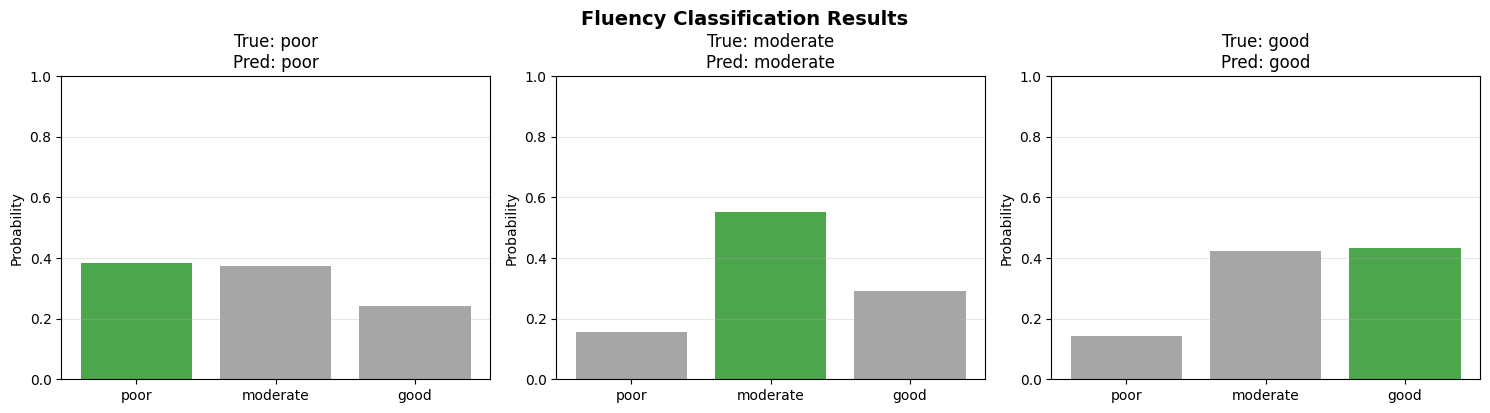

In [21]:
# Create visualization of predictions
fig, axes = plt.subplots(1, len(results_list), figsize=(15, 4))

for idx, (ax, result) in enumerate(zip(axes, results_list)):
    labels = list(result['probabilities'].keys())
    probs = list(result['probabilities'].values())
    
    colors = ['green' if label == result['predicted_label'] else 'gray' for label in labels]
    
    ax.bar(labels, probs, color=colors, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title(f"True: {result['true_label']}\nPred: {result['predicted_label']}")
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Fluency Classification Results', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 7. Batch Evaluation

In [22]:
# Evaluate on a larger subset
num_samples = min(20, len(test_df))
test_subset = test_df.sample(n=num_samples, random_state=42)

predictions = []
true_labels = []

print(f"Evaluating on {num_samples} random samples...\n")

for idx, row in test_subset.iterrows():
    result = predict_fluency(row['audio_path'], model, cfg, cmvn_stats, verbose=False)
    predictions.append(result['predicted_label'])
    true_labels.append(row['label'])

# Calculate accuracy
correct = sum(p == t for p, t in zip(predictions, true_labels))
accuracy = correct / len(predictions)

print(f"Accuracy: {accuracy:.2%} ({correct}/{len(predictions)})")

Evaluating on 20 random samples...

Accuracy: 45.00% (9/20)


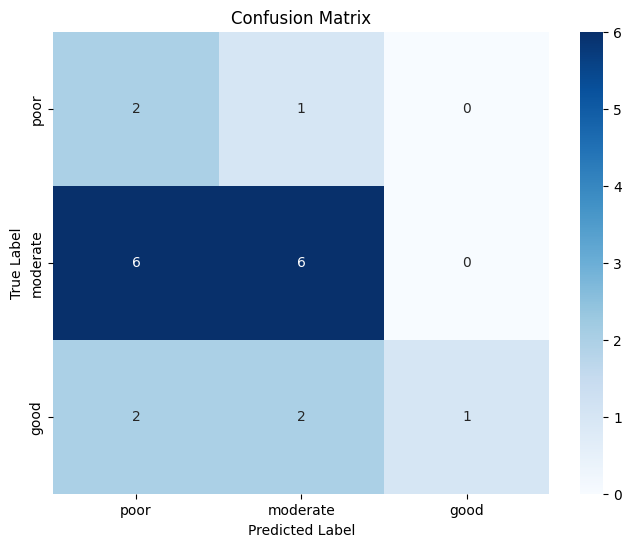


Classification Report:
              precision    recall  f1-score   support

        poor       0.20      0.67      0.31         3
    moderate       0.67      0.50      0.57        12
        good       1.00      0.20      0.33         5

    accuracy                           0.45        20
   macro avg       0.62      0.46      0.40        20
weighted avg       0.68      0.45      0.47        20



In [23]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, predictions, labels=list(label_map.keys()))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_map.keys(), 
            yticklabels=label_map.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, labels=list(label_map.keys())))

## 8. ONNX Model Inference

The model has been exported to ONNX format for edge deployment. Let's test the ONNX model.

In [24]:
import onnxruntime as ort

# Load ONNX model
onnx_path = Path('experiments/exports/model.onnx')
ort_session = ort.InferenceSession(str(onnx_path))

# Get input/output info
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

print(f"ONNX model loaded from {onnx_path}")
print(f"\nInput: {input_name}")
print(f"  Shape: {ort_session.get_inputs()[0].shape}")
print(f"  Type: {ort_session.get_inputs()[0].type}")
print(f"\nOutput: {output_name}")
print(f"  Shape: {ort_session.get_outputs()[0].shape}")
print(f"  Type: {ort_session.get_outputs()[0].type}")

ONNX model loaded from experiments/exports/model.onnx

Input: input
  Shape: ['batch', 60, 500]
  Type: tensor(float)

Output: logits
  Shape: ['batch', 3]
  Type: tensor(float)


In [25]:
def predict_fluency_onnx(audio_path, ort_session, cfg, cmvn_stats=None):
    """
    Predict fluency score using ONNX model.
    """
    # Load and preprocess audio
    clip_range = cfg['data'].get('clip_seconds', [1, 5])
    audio = preprocess(
        audio_path,
        cfg['data']['sample_rate'],
        clip_range[0],
        clip_range[1],
        cfg['augmentation'].get('trim_db', 25),
        cfg['augmentation'].get('vad_threshold', 0.5),
        cfg['augmentation'].get('peak_normalize', True)
    )
    
    # Extract features
    features = extract_features(audio, cfg['data']['sample_rate'], cfg['features'])
    
    # Apply CMVN if stats are available
    if cmvn_stats is not None and cfg['features'].get('cmvn') == 'global':
        features = apply_cmvn(features, 'global', cmvn_stats)
    
    # Features are in shape (n_features, n_frames)
    # ONNX model expects (batch, n_features, n_frames)
    
    # Pad or truncate frames to match expected size
    target_frames = export_summary['frames']
    if features.shape[1] < target_frames:
        # Pad with zeros
        padding = np.zeros((features.shape[0], target_frames - features.shape[1]))
        features = np.hstack([features, padding])
    else:
        # Truncate
        features = features[:, :target_frames]
    
    # ONNX expects (batch, n_features, n_frames) in float32
    x = features.astype(np.float32)[np.newaxis, :, :]  # Add batch dimension
    
    # Run inference
    input_name = ort_session.get_inputs()[0].name
    output_name = ort_session.get_outputs()[0].name
    
    logits = ort_session.run([output_name], {input_name: x})[0]
    
    # Convert to probabilities
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    pred_class = np.argmax(probs, axis=1)[0]
    pred_label = id_to_label[pred_class]
    confidence = probs[0, pred_class]
    
    return {
        'predicted_label': pred_label,
        'confidence': confidence,
        'probabilities': {id_to_label[i]: probs[0, i] for i in range(len(label_map))}
    }

# Test ONNX model on the same sample
print("Testing ONNX model on the first sample...\n")
sample_audio = samples[0]['audio_path']

# PyTorch prediction
print("PyTorch model:")
pytorch_result = predict_fluency(sample_audio, model, cfg, cmvn_stats, verbose=False)
print(f"  Prediction: {pytorch_result['predicted_label']} ({pytorch_result['confidence']:.2%})")

# ONNX prediction
print("\nONNX model:")
onnx_result = predict_fluency_onnx(sample_audio, ort_session, cfg, cmvn_stats)
print(f"  Prediction: {onnx_result['predicted_label']} ({onnx_result['confidence']:.2%})")

# Compare probabilities
print("\nProbability comparison:")
print(f"{'Class':<12} {'PyTorch':<12} {'ONNX':<12} {'Diff':<12}")
print("-" * 48)
for label in label_map.keys():
    pt_prob = pytorch_result['probabilities'][label]
    onnx_prob = onnx_result['probabilities'][label]
    diff = abs(pt_prob - onnx_prob)
    print(f"{label:<12} {pt_prob:<12.4f} {onnx_prob:<12.4f} {diff:<12.6f}")

Testing ONNX model on the first sample...

PyTorch model:
  Prediction: poor (38.46%)

ONNX model:
  Prediction: poor (97.75%)

Probability comparison:
Class        PyTorch      ONNX         Diff        
------------------------------------------------
poor         0.3846       0.9775       0.592828    
moderate     0.3726       0.0224       0.350200    
good         0.2428       0.0002       0.242628    


## 9. Model Performance Metrics

In [26]:
# Load performance summary if available
profile_summary_path = Path('results/profile_summary.json')
if profile_summary_path.exists():
    with open(profile_summary_path) as f:
        profile_data = json.load(f)
    
    print("Model Performance Summary:")
    print("=" * 60)
    
    # Model size
    onnx_size = onnx_path.stat().st_size / (1024 * 1024)
    print(f"ONNX Model size: {onnx_size:.2f} MB")
    
    # Latency
    if 'latency_ms' in profile_data:
        print(f"Inference latency: {profile_data['latency_ms']:.2f} ms")
    
    # Throughput
    if 'throughput' in profile_data:
        print(f"Throughput: {profile_data['throughput']:.2f} samples/sec")
else:
    print("Profile summary not found. Run 'make profile' to generate performance metrics.")

# Model size comparison
checkpoint_size = checkpoint_path.stat().st_size / (1024 * 1024)
onnx_size = onnx_path.stat().st_size / (1024 * 1024)

print(f"\nModel Size Comparison:")
print(f"  PyTorch checkpoint: {checkpoint_size:.2f} MB")
print(f"  ONNX model: {onnx_size:.2f} MB")
print(f"  Compression ratio: {checkpoint_size / onnx_size:.2f}x")

Model Performance Summary:
ONNX Model size: 14.68 MB

Model Size Comparison:
  PyTorch checkpoint: 14.68 MB
  ONNX model: 14.68 MB
  Compression ratio: 1.00x
